In [1]:
########### Old stuff ###########
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
from solvel0 import solvel0

%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import default_rng
import pandas as pd

import sys; sys.path.append('../')
from PDE_FIND import *

import os
import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from function_collections import BIC_AIC
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

########### add ons ###########
import scipy.io as sio
from scipy.signal import savgol_filter, butter, filtfilt, wiener
from scipy import integrate
from scipy.integrate import simpson, trapz, romb
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

def evaluate_coefficients(prediected_coeffs):
    assert len(prediected_coeffs.flatten()) == 2
    errs = 100*np.abs(prediected_coeffs.flatten()+1)
    return errs.mean(), errs.std()

def percent_coeff(pred, ground):
    return 100*np.abs(pred-ground)/np.abs(ground)

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from sympy import symbols, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from misc import h5file

import derivative
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise
from functools import partial
from findiff import FinDiff

from tqdm import tqdm, trange
from tsmoothie.smoother import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


Domain shape: (512, 501)
Clean data be like...


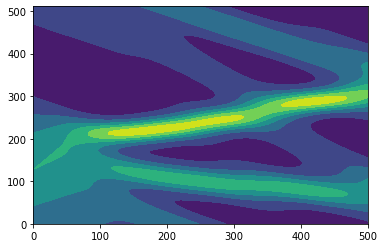

In [2]:
# Two versions (1) KdV_rudy_{solver_name} & (2) KdV_sine_rep_{solver_name}
data = sio.loadmat('../Datasets/KdV_sine_rep_big.mat')
u = real(data['usol'])
x = data['x'][0]
t = data['t'][0]
print("Domain shape:", u.shape)
dt = t[1]-t[0]
dx = x[1]-x[0]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Plot
print("Clean data be like...")
plt.contourf(u)
plt.show()

In [3]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=2, time_diff = 'FD', space_diff = 'FD')

# Solve with STRidge using 2-norm normalization
w = TrainSTRidge(R,Ut,1e-6,1,l0_penalty=1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1
PDE derived using STRidge
u_t = (-1.000814 +0.000000i)uu_{x}
    + (-1.002643 +0.000000i)u_{xxx}
   


In [4]:
np.random.seed(0)
noise_lv = 30
un = u + 0.01*abs(noise_lv)*u.std()*np.random.randn(*u.shape)

In [5]:
is_u_denoised = True
if is_u_denoised:
    print("Loading denoised data...")
    # un = np.load("./denoised_files/KdV_rep_sine_noise30_reduced_dysmho_25x25.npy")
    un = np.load("./denoised_files/KdV_rep_sine_noise30_reduced_dctV2ksvdreg_25x25.npy")

Loading denoised data...


In [6]:
### originally from derivative ###
## slow ##
# diff_name, diff_func_kwargs = "Kalman", {'alpha':kalpha}
## fast ##
# diff_name, diff_func_kwargs = "FiniteDifference", {'k':1}
# differentiation_method = Differentiator
# differentiation_kwargs = {"diff_name": diff_name, "diff_func_kwargs": diff_func_kwargs}

# originally from pysindy
differentiation_method, differentiation_kwargs = ps.FiniteDifference, {}
# differentiation_method, differentiation_kwargs = ps.SmoothedFiniteDifference, {}

# originally from findiff (accurate and fast)
# differentiation_method, differentiation_kwargs = FiniteDifferentiator, {'acc':4}

diff_order = 4
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=4, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}

In [7]:
# optimizer = BruteForceRegressor(3)
# if feature_library=weak_pde_lib, then just differentiation_method=None is fine.
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=2+1, lam=1e-4, is_normal=True, normalize_columns=False, threshold=1e-4)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=2, alpha=1e-4, normalize_columns=False, regression_timeout=100)
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method(**differentiation_kwargs), 
                 cache=True,
                 feature_names=['u'])

In [8]:
model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
print(model.get_feature_names())
X_pre, y_pre = np.squeeze(model.feature_library.cached_xp_full), model.cached_x_dot

Set parameter Username


2023-12-17 22:06:19,354 [INFO] Set parameter Username


Academic license - for non-commercial use only - expires 2024-06-04


2023-12-17 22:06:19,356 [INFO] Academic license - for non-commercial use only - expires 2024-06-04


['u', 'uu', 'u_1', 'u_11', 'u_111', 'u_1111', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11', 'uu_111', 'uuu_111', 'uu_1111', 'uuu_1111']


In [9]:
def hierarchy(fitted_model, dataset, target_index=0, field=0):
    Xd, yd = dataset
    yd = yd[:, target_index]
    model_results = {}
    for effective_indices in fitted_model:
        com = len(effective_indices)
        X_pre_sup = Xd[:, effective_indices]
        solve = np.linalg.lstsq(X_pre_sup, yd, rcond=None)
        coeff = solve[0]
        if len(solve[1]) == 1:
            mse = solve[1][0]
            if (com not in model_results) or model_results[com][-1] > mse:
                model_results[com] = effective_indices, coeff, mse
    if field < 0: 
        return model_results
    else: 
        dkeys = model_results.keys()
        dvals = (lambda lst, _: [t[_] for t in lst if len(t)>_])(model_results.values(), field)
        return dict(zip(dkeys, dvals))

def hierarchy_sindy(fitted_model, dataset, target_index=0):
    Xd, yd = dataset
    target_index = 0
    model_results = {}
    model_coef_array = np.array(fitted_model.get_coef_list())[:, target_index, :].T
    # mses = (((Xd@(model_coef_array))-yd)**2).mean(axis=0)
    eff = np.apply_along_axis(lambda arr: np.where(arr != 0, 1, arr), 
                              axis=-1, arr=model_coef_array).T

    for i in range(eff.shape[0]-1):
        effective_indices = tuple(np.where(eff[i]>0)[0])
        X_pre_sup = Xd[:, effective_indices]
        com = len(effective_indices)

        solve = np.linalg.lstsq(X_pre_sup, yd, rcond=None)
        coeff = solve[0]
        # mse = ((X_pre_sup@coeff-yd)**2).mean()
        if len(solve[1]) == 1:
            mse = solve[1][0]
            if (com not in model_results) or model_results[com][-1] > mse:
                model_results[com] = effective_indices, coeff, mse

    return model_results

In [10]:
model_results = hierarchy_sindy(model, (X_pre, y_pre))
# assert model_results[2][0] == (4, 6)
model_results

{2: ((4, 6),
  array([[-0.90371676],
         [-0.91031006]]),
  51.956739271436966)}

In [11]:
solvel0(X_pre, y_pre, intercept=False, refine=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 27.39it/s]


Call backward_refinement...


[(6,),
 (4, 6),
 (4, 6, 10),
 (4, 6, 7, 10),
 (2, 4, 6, 10, 11),
 (0, 2, 4, 6, 10, 11),
 (0, 2, 4, 6, 8, 10, 11),
 (0, 2, 4, 6, 7, 8, 10, 11),
 (0, 2, 3, 4, 6, 7, 8, 10, 11),
 (0, 2, 3, 4, 6, 7, 8, 9, 10, 11),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

In [12]:
bf_solve, best_subsets = brute_force_all_subsets(X_pre, y_pre) # compare solvel0's res to bf_solve
best_subsets

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.06s/it]


[(6,),
 (4, 6),
 (4, 6, 10),
 (4, 6, 7, 10),
 (2, 4, 6, 10, 11),
 (0, 2, 4, 6, 10, 11),
 (0, 2, 4, 6, 8, 10, 11),
 (0, 2, 4, 6, 7, 8, 10, 11),
 (0, 2, 3, 4, 6, 7, 8, 10, 11),
 (0, 2, 3, 4, 6, 7, 8, 9, 10, 11),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

In [13]:
# optimizer_name = "miosr" # "l0bnb", "miosr"
# print(optimizer_name)
# assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
# n_ensemble_models = 50; miosr_alpha = 1e-4
# all_eff_rhs = []
# for mnz in range(1, 9):
#     print(mnz)    
#     if optimizer_name == "l0bnb":
#         optimizer = L0BNB(max_nonzeros=mnz, lam=miosr_alpha, is_normal=True, normalize_columns=False, threshold=1e-4)
#     elif optimizer_name == "miosr":
#         optimizer = ps.MIOSR(target_sparsity=mnz, alpha=5e-2, normalize_columns=False, regression_timeout=100)
#     model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
#                      differentiation_method=differentiation_method(**differentiation_kwargs), 
#                      cache=True,
#                      feature_names=['u'])
#     model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
#               library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    
#     # ols_model, eff_rhs_indices = model.validate_coef_list()[0]
#     # all_eff_rhs.append(eff_rhs_indices)
#     all_eff_rhs.extend([v[0] for v in hierarchy_sindy(model, (X_pre, y_pre)).values()])

In [14]:
mode = 'rfe'; ic_type = 'bic'
st = backward_refinement(best_subsets, (X_pre, y_pre), 
                         mode=mode, ic_type=ic_type, verbose=False)
st.track

{1: ((6,), -2592.600598870076),
 2: ((4, 6), -24202.09802250475),
 3: ((4, 6, 10), -24516.283556873415),
 4: ((4, 6, 7, 10), -24738.582027346103),
 5: ((2, 4, 6, 10, 11), -24999.10330775339),
 6: ((0, 2, 4, 6, 10, 11), -24999.657216473453),
 7: ((0, 2, 4, 6, 8, 10, 11), -25011.926687778185),
 8: ((0, 2, 4, 6, 7, 8, 10, 11), -25008.6178814571),
 9: ((0, 2, 3, 4, 6, 7, 8, 10, 11), -25001.94884392114),
 10: ((0, 2, 3, 4, 6, 7, 8, 9, 10, 11), -24995.82260426318),
 11: ((0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11), -24986.941380697284),
 12: ((0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12), -24977.791968231177),
 13: ((0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13), -24968.618676171485),
 14: ((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13), -24959.417524022207)}

In [15]:
# w/o denoise: -16613.85200875413
# w/ denoise: -22419.32608890811
decreasing_aics = []
complexities = []
eff_feature_names = []
now_aic = 1e6
for com in sorted(st.track.keys()):
    indices, aic = st.track[com]
    aic = getattr(sm.OLS(y_pre, X_pre[:, indices]).fit(), ic_type)
    print(indices, aic)
    if aic < now_aic:
        complexities.append(len(indices))
        decreasing_aics.append(aic)
        eff_feature_names.append([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in indices])
        now_aic = aic
    # print(decreasing_aics, complexities)
decreasing_aics = np.array(decreasing_aics)
complexities = np.array(complexities)
relative_decreasing_aics = decreasing_aics-np.min(decreasing_aics)
min(decreasing_aics)-max(decreasing_aics)

(6,) -2592.600598870076
(4, 6) -24202.09802250475
(4, 6, 10) -24516.283556873415
(4, 6, 7, 10) -24738.582027346103
(2, 4, 6, 10, 11) -24999.10330775339
(0, 2, 4, 6, 10, 11) -24999.657216473453
(0, 2, 4, 6, 8, 10, 11) -25011.926687778185
(0, 2, 4, 6, 7, 8, 10, 11) -25008.6178814571
(0, 2, 3, 4, 6, 7, 8, 10, 11) -25001.94884392114
(0, 2, 3, 4, 6, 7, 8, 9, 10, 11) -24995.82260426318
(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11) -24986.941380697284
(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12) -24977.791968231177
(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13) -24968.618676171485
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13) -24959.417524022207


-22419.32608890811

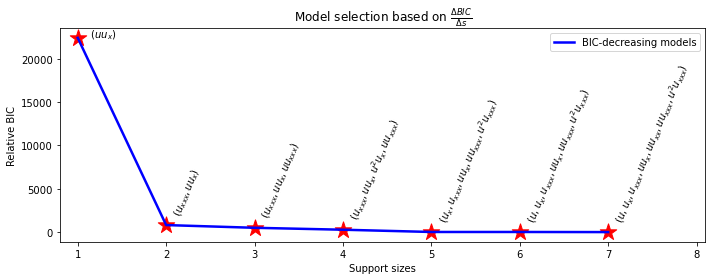

In [16]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(complexities, relative_decreasing_aics, color='blue', linewidth=2.5, label="BIC-decreasing models")
ax.scatter(complexities, relative_decreasing_aics, marker='*', c='red', s=300)
for com, name, rel_aic in zip(complexities, eff_feature_names, relative_decreasing_aics):
    rotation = (90+45)/2
    if com == 1: rotation = 0
    ax.annotate(f"    $({','.join(name)})$", (com, rel_aic), rotation=rotation)
plt.xlim(0.8,8.1)
plt.title(r"Model selection based on $\frac{\Delta BIC}{\Delta s}$")
plt.ylabel("Relative BIC")
plt.xlabel("Support sizes")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
good_coms = set()
min_pok = 1e-3 # 1e-2, 1e-3
max_pok = 1.
delta_pok = min_pok
for p in np.arange(min_pok, max_pok+delta_pok, delta_pok):
    c = find_transition_V5(decreasing_aics, complexities, percent_ok=p, verbose=False)
    if c == 1: break
    good_coms.add(c)
good_coms

{2, 3}

In [18]:
print(decreasing_aics[1]-decreasing_aics[0])
decreasing_aics, complexities, eff_feature_names

-21609.497423634675


(array([ -2592.60059887, -24202.0980225 , -24516.28355687, -24738.58202735,
        -24999.10330775, -24999.65721647, -25011.92668778]),
 array([1, 2, 3, 4, 5, 6, 7]),
 [['uu_{x}'],
  ['u_{xxx}', 'uu_{x}'],
  ['u_{xxx}', 'uu_{x}', 'uu_{xxx}'],
  ['u_{xxx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xxx}'],
  ['u_{x}', 'u_{xxx}', 'uu_{x}', 'uu_{xxx}', 'u^2u_{xxx}'],
  ['u', 'u_{x}', 'u_{xxx}', 'uu_{x}', 'uu_{xxx}', 'u^2u_{xxx}'],
  ['u', 'u_{x}', 'u_{xxx}', 'uu_{x}', 'uu_{xx}', 'uu_{xxx}', 'u^2u_{xxx}']])

#### Model selection

[ 1.          2.03019684  3.40361152  5.849084    6.33295821  6.46745809
  6.84046346  9.48491114 10.26650985 11.94545695 12.33645285 12.5176906
 14.53742696 15.75503672]
7,5,2,

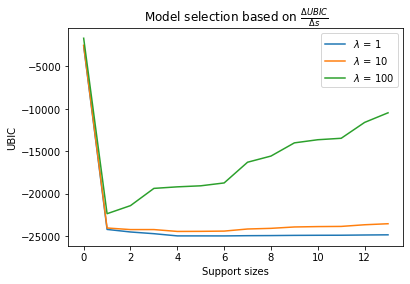

In [19]:
baye_alpha = 1e-6
mul_val = 1
brr_uncertainties = []
brr_bics = []
for com in sorted(st.track.keys()):
    brr = BayesianRidge(compute_score=True, alpha_1=baye_alpha, alpha_2=baye_alpha)
    brr.fit(X_pre[:, st.track[com][0]], y_pre)
    uncert = mul_val*np.trace(np.sqrt(brr.sigma_))
    brr_uncertainties.append(uncert)
    brr_bics.append((brr.predict(X_pre[:, st.track[com][0]]).reshape(-1, 1), 
                     np.count_nonzero(brr.coef_), 
                     uncert))

brr_uncertainties = np.array(brr_uncertainties)
mul_val = 1/brr_uncertainties.min()
print(brr_uncertainties*mul_val)

for kkk in [1, 10, 100]:
    brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+kkk*mul_val*brr_uncert)[0] 
                   for brr_pred, brr_com, brr_uncert in brr_bics]
    print(np.argmin(brr_bicaics)+1, end=',')
    plt.plot(brr_bicaics, label="$\lambda$ = "+f'{kkk}')
plt.title(r"Model selection based on $\frac{\Delta UBIC}{\Delta s}$")
plt.xlabel("Support sizes")
plt.ylabel("UBIC")
plt.legend()
plt.show()

[ 1.          2.02914346  3.40219848  5.84634033  6.32662949  6.46067659
  6.78353485  9.42657394 10.08577202 11.3086703  11.93805983 12.35945732
 14.38026406 15.60212946]
7
5
2


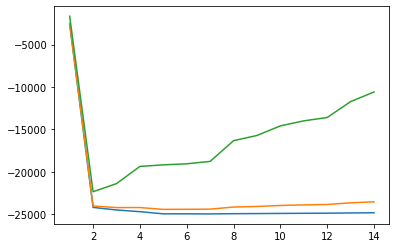

In [20]:
OLS_results = []
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    OLS_results.append(sm.OLS(y_pre, X_pre[:, indices]).fit())
    
uncertainties = np.array([sum(res.bse) for res in OLS_results])
uncertainties = uncertainties/uncertainties.min()
print(uncertainties)

BICs = np.array([getattr(res, ic_type) for res in OLS_results])
UBICs_list = []
for lam in [1,10,100]:
    UBICs = (BICs + lam*np.log(len(y_pre))*uncertainties).tolist()
    UBICs_list.append(UBICs)
    print(np.argmin(UBICs)+1)
    plt.plot([i+1 for i in range(len(UBICs))], UBICs)
plt.show()

[ 1.          2.03134903  3.36685928  6.12167255  6.5786787   6.70615088
  7.02155719  9.59123401 10.34545014 11.50914326 12.18946166 12.64342009
 14.59656945 15.77368496]
7
5
2


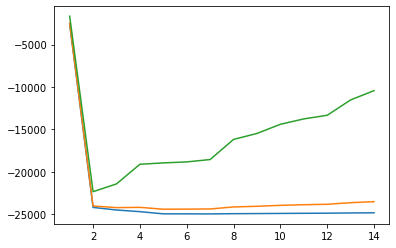

In [21]:
OLS_results = []
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    OLS_results.append(sm.OLS(y_pre, X_pre[:, indices]).fit(cov_type="HC0"))
    
uncertainties = np.array([sum(res.bse) for res in OLS_results])
uncertainties = uncertainties/uncertainties.min()
print(uncertainties)

BICs = np.array([getattr(res, ic_type) for res in OLS_results])
UBICs_list = []
for lam in [1,10,100]:
    UBICs = (BICs + lam*np.log(len(y_pre))*uncertainties).tolist()
    UBICs_list.append(UBICs)
    print(np.argmin(UBICs)+1)
    plt.plot([i+1 for i in range(len(UBICs))], UBICs)
plt.show()

In [22]:
from UBIC import *

In [23]:
best_subsets = sorted([indices for _, (indices, _) in st.track.items()], key=lambda _: len(_))

n_lams = 3
ics, bc, lam = UBICs(best_subsets, 
                     (X_pre, y_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     delta=(1+1/3), n_lams=n_lams)
ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[5.60060263 1.         1.59622049 2.6046235  2.61498128 2.66638277
 2.79120634 3.88160145 4.15068725 4.63599157 4.89011884 5.06351247
 5.88817818 6.38934212]
0 ---> 7
1.3333333333333333 ---> 5
2.6666666666666665 ---> 2
4.0 ---> 2
5.333333333333333 ---> 2
[ 21350.31896586 -19927.03672007 -17692.34312255 -13603.65690412
 -13819.89801945 -13600.7074076  -13079.34846062  -8414.53372065
  -7257.50639356  -5176.67443917  -4081.38355387  -3330.9657591
    203.70400243   2355.41171703]
The optimal complexity is currently at the support sizes of 2.


(array([ 21350.31896586, -19927.03672007, -17692.34312255, -13603.65690412,
        -13819.89801945, -13600.7074076 , -13079.34846062,  -8414.53372065,
         -7257.50639356,  -5176.67443917,  -4081.38355387,  -3330.9657591 ,
           203.70400243,   2355.41171703]),
 1,
 2.6666666666666665)

In [24]:
_, _, b_uns = baye_uncertainties([v[0] for v in st.track.values()], (X_pre, y_pre), u_type='cv', take_sqrt=True)
lower_bounds = []
for efi in [v[0] for v in st.track.values()]:
    com = len(efi)
    w = np.linalg.lstsq(X_pre[:, efi], y_pre, rcond=None)[0]
    pred = X_pre[:, efi]@w
    lower_bound = log_like_value(pred, y_pre)/np.log(len(y_pre))-com
    lower_bounds.append(lower_bound)
max_lam = max(np.log10(lower_bounds/b_uns))
delta = np.linspace(0, max_lam, 4)[1]
max_lam

3.118216664166924

In [25]:
n_lams = 3
ics, bc, lam = UBICs([v[0] for v in st.track.values()], 
                     (X_pre, y_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     max_lam=max_lam,
                     delta=delta, 
                     n_lams=n_lams)
# ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[5.60060263 1.         1.59622049 2.6046235  2.61498128 2.66638277
 2.79120634 3.88160145 4.15068725 4.63599157 4.89011884 5.06351247
 5.88817818 6.38934212]
0 ---> 7
1.039405554722308 ---> 5
2.078811109444616 ---> 2
3.118216664166924 ---> 2
[  3592.14085727 -23097.79874132 -22753.57842042 -21862.29817088
 -22111.38135695 -22055.17263727 -21929.59952878 -20722.16818769
 -20418.34789492 -19876.30044446 -19586.78665831 -19386.15878885
 -18466.30774468 -17903.67161476]
The optimal complexity is currently at the support sizes of 2.


In [26]:
lam

2.078811109444616

In [27]:
best_subsets = sorted([v[0] for v in st.track.values()], key=len)
ols_models = [sm.OLS(y_pre, X_pre[:, efi]).fit() for efi in best_subsets]
f_res = sm.stats.anova_lm(*ols_models, test="F", robust="hc3") # "F", "Chisq"", "Cp"
print(np.argmax(f_res.F)+1)
f_res

2


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,9999.0,451.367657,0.0,NaN,NaN,NaN
1,9998.0,51.956739,1.0,399.410918,83725.851736,0.000000e+00
2,9997.0,50.303359,1.0,1.653381,346.587167,4.497272e-76
3,9996.0,49.152169,1.0,1.151190,241.316322,8.617435e-54
4,9995.0,47.844100,1.0,1.308069,274.201739,8.854218e-61
5,9994.0,47.797406,1.0,0.046693,9.788020,1.761575e-03
6,9993.0,47.694849,1.0,0.102558,21.498497,3.585970e-06
7,9992.0,47.666710,1.0,0.028139,5.898586,1.517057e-02
8,9991.0,47.654598,1.0,0.012112,2.538961,1.110995e-01
9,9990.0,47.639903,1.0,0.014695,3.080392,7.927206e-02


In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from k_means_constrained import KMeansConstrained

clf = KMeansConstrained(
    n_clusters=2, size_min=1, size_max=len(complexities)-1, 
    random_state=0, 
)
clf.fit(np.vstack((decreasing_aics, complexities)).T)
# silhouette_avg = silhouette_score(X, clf.labels_)
clf.labels_,  clf.cluster_centers_

(array([1, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([[-2.47446085e+04,  4.50000000e+00],
        [-2.59260060e+03,  1.00000000e+00]]))

#### UBIC

In [29]:
tau = 3 # we fix its value as a constant
scale = np.log(len(y_pre))
scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(slopes, 85)
thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
#     lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
#     if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
#         break
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam, last_ubic, last_bc, best_bc

0.02
1 <---> 1 inf
1 <---> 6 0.006692218703687602


(2.922568677047628,
 array([  2093.41183791, -23365.4001262 , -23180.72923332, -22559.299026  ,
        -22811.15396963, -22768.70035985, -22676.53021183, -21760.89011191,
        -21529.07755179, -21116.89820923, -20895.3892327 , -20741.1617378 ,
        -20041.99238001, -19613.46841427]),
 1,
 1)

In [31]:
tau = 3 # we fix its value as a constant
scale = np.log(len(y_pre))
# scale = 1
pers = np.arange(50+5, 100+5, 5, dtype=np.int32)
success_counts = 0
all_counts = 0

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
#     lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])

for per in pers:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
    # print(thres)

    last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
    delta = last_lam/tau
    now_lam = last_lam-delta
    last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
    last_bc = np.argmin(last_ubic)
    while now_lam >= 0:
        now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
        now_bc = np.argmin(now_ubic)

        diff_com = now_bc-last_bc
        diff_bic = b_bics[now_bc]-b_bics[last_bc]
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))

        # print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

        if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp > thres):
            break

        last_lam = now_lam
        now_lam = round(last_lam-delta, 10)
        last_ubic = now_ubic
        last_bc = now_bc
    
    if last_bc == 1:
        success_counts += 1
    all_counts += 1
    print(last_bc, end=', ')
   
# 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 
# Success rate: 80.0
print("\nSuccess rate:", 100*success_counts/all_counts)

4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 
Success rate: 80.0


In [41]:
tau = 3 # we fix its value as a constant
scale = np.log(len(y_pre))
scale = 1
per = 75

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(slopes, per)
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
#     lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
#     if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
#         break
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam, last_ubic, last_bc, best_bc

0.012369053553838464
1 <---> 1 inf
1 <---> 6 0.006692218703687602


(2.922568677047628,
 array([  2093.41183791, -23365.4001262 , -23180.72923332, -22559.299026  ,
        -22811.15396963, -22768.70035985, -22676.53021183, -21760.89011191,
        -21529.07755179, -21116.89820923, -20895.3892327 , -20741.1617378 ,
        -20041.99238001, -19613.46841427]),
 1,
 1)

In [42]:
min(b_bics)-max(b_bics)

-22419.32608890811

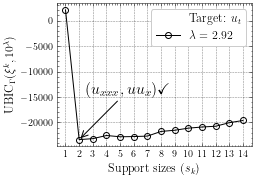

In [43]:
complexity_axis = list(st.track.keys())
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $u_t$')
    ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(round(last_lam, 2))}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('$(u_{xxx}, uu_{x})\checkmark$', fontsize=16,  
                 xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+9000), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12)
#     fig.savefig("../Figures/KdV/kdv_scale_ubic.pdf")
    plt.show()
    plt.close()

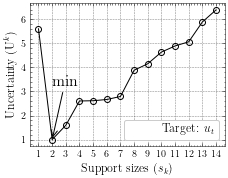

In [33]:
complexity_axis = list(st.track.keys())
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $u_t$')
    ax.plot(complexity_axis, b_uns, 'o-', c='black', markerfacecolor='none')
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("Uncertainty ($\\textrm{U}^{k}$)", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('min', fontsize=16, 
                 xy=(complexity_axis[best_bc], b_uns[best_bc]), 
                 xytext=(complexity_axis[best_bc], b_uns[best_bc]+2.25), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12)
#     fig.savefig("../Figures/KdV/kdv_uns.pdf")
    plt.show()
    plt.close()

['X_pre', 'best_subsets', 'un', 'y_pre']


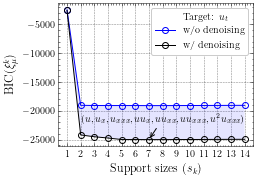

In [34]:
ud_X, un_best_subsets, _, ud_y = h5file("./IPI_output_files/PMS_undenoised_data.h5", 'r')
_, ud_bics, _ = baye_uncertainties([np.where(e>0)[0].tolist() for e in un_best_subsets], 
                                   (ud_X, ud_y), u_type='cv1', take_sqrt=True)

complexity_axis = list(st.track.keys())
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $u_t$')
    ax.plot(complexity_axis, ud_bics, 'o-', c='blue', markerfacecolor='none', label="w/o denoising")
    ax.plot(complexity_axis, b_bics, 'o-', c='black', markerfacecolor='none', label="w/ denoising")
    ax.fill_between(complexity_axis, ud_bics, b_bics, facecolor='blue', alpha=0.1)
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{BIC}(\\xi^{k}_{\\mu})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate(f"$({', '.join(eff_feature_names[np.argmin(b_bics)])})$", fontsize=10, 
                 xy=(complexity_axis[np.argmin(b_bics)], b_bics[np.argmin(b_bics)]), 
                 xytext=(complexity_axis[np.argmin(b_bics)]-5, b_bics[np.argmin(b_bics)]+3000), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=10)
#     fig.savefig("../Figures/KdV/kdv_bic.pdf")
    plt.show()
    plt.close()

#### IC on validation data

In [35]:
from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold

100%|███████████████████████████████████████████| 14/14 [00:06<00:00,  2.05it/s]


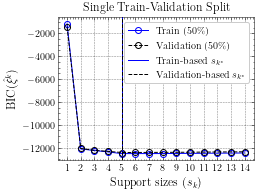

In [36]:
div = 0.5
n_train = int(len(X_pre)*div)
X_train = X_pre.copy()[:n_train, :]
y_train = y_pre.copy()[:n_train, :]
X_val = X_pre.copy()[n_train:, :]
y_val = y_pre.copy()[n_train:, :]

complexity_axis = list(st.track.keys())
train_bics = []
val_bics = []
for _ in trange(1, max(complexity_axis)+1):
    w_train = brute_force(X_train, y_train, _)
    w_train_pred = X_val@w_train
    train_bics.append(BIC_AIC(X_train@w_train, y_train, _)[0])
    val_bics.append(BIC_AIC(w_train_pred, y_val, _)[0])
    
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot(complexity_axis, train_bics, 'o-', c='blue', markerfacecolor='none', label='Train (50\%)')
    ax.plot(complexity_axis, val_bics, 'o--', c='black', markerfacecolor='none', label='Validation (50\%)')
    ax.axvline(x=np.argmin(train_bics)+1, linestyle='-', c='blue', label='Train-based $s_{k^{*}}$')
    ax.axvline(x=np.argmin(val_bics)+1, linestyle='--', c='black', label='Validation-based $s_{k^{*}}$')
    ax.set_xticks(complexity_axis)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    ax.set_ylabel("$\\textrm{BIC}(\\hat{\\xi}^{k})$", fontsize=12)
    ax.set_title("Single Train-Validation Split", fontsize=12)
    ax.legend()
    fig.savefig("../Figures/KdV/kdv_crossval.pdf")
    plt.show()

100%|███████████████████████████████████████████| 14/14 [00:07<00:00,  1.80it/s]


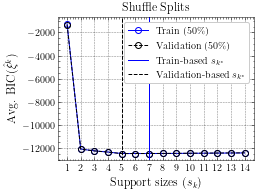

In [37]:
spliter = ShuffleSplit(n_splits=10, random_state=0, test_size=0.5)

train_avg_bics = []
val_avg_bics = []
for i, (train_index, test_index) in enumerate(spliter.split(X_pre)):
    X_train = X_pre.copy()[train_index, :]
    y_train = y_pre.copy()[train_index, :]
    X_val = X_pre.copy()[test_index, :]
    y_val = y_pre.copy()[test_index, :]
    train_bics = []
    val_bics = []
    for _ in trange(1, max(complexity_axis)+1):
        w_train = brute_force(X_train, y_train, _)
        w_train_pred = X_val@w_train
        train_bics.append(BIC_AIC(X_train@w_train, y_train, _)[0])
        val_bics.append(BIC_AIC(w_train_pred, y_val, _)[0])
    train_avg_bics.append(train_bics)
    val_avg_bics.append(val_bics)
    
train_avg_bics = np.array(train_avg_bics)
val_avg_bics = np.array(val_avg_bics)
train_bics = train_avg_bics.mean(axis=0)
val_bics = val_avg_bics.mean(axis=0)

complexity_axis = list(st.track.keys())
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot(complexity_axis, train_bics, 'o-', c='blue', markerfacecolor='none', label='Train (50\%)')
    ax.plot(complexity_axis, val_bics, 'o--', c='black', markerfacecolor='none', label='Validation (50\%)')
    ax.axvline(x=np.argmin(train_bics)+1, linestyle='-', c='blue', label='Train-based $s_{k^{*}}$')
    ax.axvline(x=np.argmin(val_bics)+1, linestyle='--', c='black', label='Validation-based $s_{k^{*}}$')
    ax.set_xticks(complexity_axis)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    ax.set_ylabel("Avg. $\\textrm{BIC}(\\hat{\\xi}^{k})$", fontsize=12)
    ax.set_title("Shuffle Splits", fontsize=12)
    ax.legend()
    fig.savefig("../Figures/KdV/kdv_crossval_sss.pdf")
    plt.show()

100%|███████████████████████████████████████████| 14/14 [00:07<00:00,  1.87it/s]


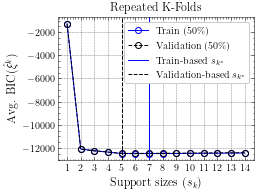

In [38]:
spliter = RepeatedKFold(n_splits=2, n_repeats=5, random_state=0)

train_avg_bics = []
val_avg_bics = []
for i, (train_index, test_index) in enumerate(spliter.split(X_pre)):
    X_train = X_pre.copy()[train_index, :]
    y_train = y_pre.copy()[train_index, :]
    X_val = X_pre.copy()[test_index, :]
    y_val = y_pre.copy()[test_index, :]
    train_bics = []
    val_bics = []
    for _ in trange(1, max(complexity_axis)+1):
        w_train = brute_force(X_train, y_train, _)
        w_train_pred = X_val@w_train
        train_bics.append(BIC_AIC(X_train@w_train, y_train, _)[0])
        val_bics.append(BIC_AIC(w_train_pred, y_val, _)[0])
    train_avg_bics.append(train_bics)
    val_avg_bics.append(val_bics)
    
train_avg_bics = np.array(train_avg_bics)
val_avg_bics = np.array(val_avg_bics)
train_bics = train_avg_bics.mean(axis=0)
val_bics = val_avg_bics.mean(axis=0)

complexity_axis = list(st.track.keys())
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot(complexity_axis, train_bics, 'o-', c='blue', markerfacecolor='none', label='Train (50\%)')
    ax.plot(complexity_axis, val_bics, 'o--', c='black', markerfacecolor='none', label='Validation (50\%)')
    ax.axvline(x=np.argmin(train_bics)+1, linestyle='-', c='blue', label='Train-based $s_{k^{*}}$')
    ax.axvline(x=np.argmin(val_bics)+1, linestyle='--', c='black', label='Validation-based $s_{k^{*}}$')
    ax.set_xticks(complexity_axis)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    ax.set_ylabel("Avg. $\\textrm{BIC}(\\hat{\\xi}^{k})$", fontsize=12)
    ax.set_title("Repeated K-Folds")
    ax.legend()
    fig.savefig("../Figures/KdV/kdv_crossval_rkf.pdf")
    plt.show()

In [53]:
def weight_poly(x, m, k):
    """
    Polynomial piece of weighting function used to satisfy BC A = d^k/dx^k[(x^2 - 1)^m]
    x: independent variable
    m: power of base function
    k: order of derivative
    """
    a = np.zeros((2*m+1, 1)) # initial coefficient vector
    for l in range(m+1):
        a[2*l] = ((-1)**(m-l))*np.math.comb(m, l) # set polynomial coefficients
    
    c = np.zeros((2*m+1, 1)) # final coefficient vector
    for n in range(2*m-k+1):
        c[n] = a[n+k]*np.math.factorial(n+k)/np.math.factorial(n)
    
    p = 0
    for n in range(2*m-k+1):
        p += c[n]*(x**n) # final windowing function

    return p

def weight_full(k, p, x, t):
    """
    Assemble the 1D weight functions into the full weight
    k = [kx,ky,kt]: order of derivative(s)
    p = [px,py,pt]: exponents of weight polynomials
    """
    if len(k) == 3:
        wx = weight_poly(x, p[0], k[0])
        wy = weight_poly(x, p[1], k[1])
        wt = weight_poly(t, p[2], k[2])
        wX, wY, wT = np.meshgrid(wx, wy, wt)
        W = wX * wY * wT
    elif len(k) == 2:
        wx = weight_poly(x, p[0], k[0])
        wt = weight_poly(t, p[1], k[1])
        wT, wX = np.meshgrid(wt, wx)
        W = wX * wT
    
    return W, wx, wt

In [54]:
u_weak = un.copy()
n_domain = 10000
div = 3.5
x_size, t_size = int(max(u_weak.shape)/div), int(max(u_weak.shape)/div)

xsup = np.linspace(-1,1,x_size+1)
tsup = np.linspace(-1,1,t_size+1)
S_x = 2/(dx*x_size)
S_t = 2/(dt*t_size)

In [55]:
max_order = 3
best_loss = 1e6; best_coeff = None
for mo in range(max_order, max_order+10, 1):
    wx, wt = np.meshgrid((xsup**2-1)**(mo), (tsup**2-1)**(mo))
    W = (wx*wt).T
    
    # Define the derivative:
    d_dx = FinDiff(0, xsup[1]-xsup[0], 1)
    d_dxxx = FinDiff(0, xsup[1]-xsup[0], 3)
    d_dt = FinDiff(1, tsup[1]-tsup[0], 1)

    dA01 = d_dt(W)
    dA10 = d_dx(W)
    dA30 = d_dxxx(W)

    X_weak = []
    y_weak = []
    for _ in trange(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)

        usup = (u_weak[ix, :][:, it])

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, dt, 1), xsup, dx, 0)
        
        f2 = -usup*dA30*(S_x**3)
        f2 = trapz(trapz(f2, tsup, dt, 1), xsup, dx, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, dt, 1), xsup, dx, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)

    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()

    print(mo)
    print(loss, evaluate_coefficients(coeff))
    if loss < best_loss:
        best_loss = loss
        best_coeff = coeff
    else:
        break

best_mo = mo-1
best_coeff, evaluate_coefficients(coeff)

100%|███████████████████████████████████████████| 10000/10000 [00:04<00:00, 2063.53it/s]


3
7.718170793467112e-07 (0.3868821326124483, 0.3330764432911082)


100%|███████████████████████████████████████████| 10000/10000 [00:04<00:00, 2192.16it/s]


4
7.547404191165086e-07 (0.38169642642502666, 0.23922400540024036)


100%|███████████████████████████████████████████| 10000/10000 [00:04<00:00, 2234.31it/s]

5
7.624655081639678e-07 (0.28954232393045287, 0.015725191557031115)


(array([-0.9937908 , -1.00142472]),
 (0.28954232393045287, 0.015725191557031115))

In [57]:
wx, wt = np.meshgrid((xsup**2-1)**(best_mo), (tsup**2-1)**(best_mo))
W = (wx*wt).T

# Define the derivative:
d_dx = FinDiff(0, xsup[1]-xsup[0], 1, acc=4)
d_dxx = FinDiff(0, xsup[1]-xsup[0], 2, acc=4)
d_dxxx = FinDiff(0, xsup[1]-xsup[0], 3, acc=4)
d_dt = FinDiff(1, tsup[1]-tsup[0], 1, acc=4)

dA01 = d_dt(W)
dA10 = d_dx(W)
dA30 = d_dxxx(W)

np.random.seed(0)
min_loss = 1e6; best_coeff = None; best_ws = -1
for ws in trange(3, 33, 2):
    X_weak = []
    y_weak = []
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = savgol_filter(u_weak[ix, :][:, it], ws, 2)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, 1), xsup, 0)

        f2 = -usup*dA30*(S_x**3)
        f2 = trapz(trapz(f2, tsup, 1), xsup, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, 1), xsup, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff
        best_ws = ws

# (0.03524781993990561, 0.011424239600747732)

# (7.199164231608589e-07,
#  array([-0.99420847, -1.00141073]),
#  (0.36011260397684763, 0.21903991770840792),
#  29)

min_loss, best_coeff, evaluate_coefficients(best_coeff), best_ws

100%|███████████████████████████████████████████████████| 15/15 [02:59<00:00, 11.99s/it]


(7.199164231608589e-07,
 array([-0.99420847, -1.00141073]),
 (0.36011260397684763, 0.21903991770840792),
 29)

#### Saving results obtained in IPI step

In [24]:
tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))
for i in range(len(best_subsets)):
    tmp[i:i+1, :][0, best_subsets[i]] = 1.0
best_subsets = tmp.astype(np.float32)
del tmp

pms_data = {nameof(un): un, 
            nameof(X_pre): X_pre, 
            nameof(y_pre): y_pre, 
            nameof(best_subsets): best_subsets}
pms_data

{'un': array([[ 4.30889040e-02,  1.91839024e-02, -2.56449465e-02, ...,
         -6.45620862e-01, -6.53397031e-01, -5.32059944e-01],
        [ 4.85296026e-02,  2.23846413e-02, -1.81812313e-02, ...,
         -6.30331618e-01, -6.36064043e-01, -5.15069414e-01],
        [ 5.43418837e-02,  2.64724315e-02, -1.00428682e-02, ...,
         -6.14604348e-01, -6.18391249e-01, -4.98315785e-01],
        ...,
        [ 6.80875961e-03, -3.03584253e-02, -2.05221853e-02, ...,
         -5.90549407e-01, -6.06716483e-01, -6.82432608e-01],
        [ 4.49370776e-02, -2.39096476e-02,  5.48030441e-04, ...,
         -5.82733007e-01, -5.88329388e-01, -6.73655319e-01],
        [ 8.50965544e-02, -1.79157631e-02,  2.24706813e-02, ...,
         -5.75116735e-01, -5.68877548e-01, -6.64882406e-01]]),
 'X_pre': array([[ 4.78690456e+00,  9.44963227e+00, -1.23914976e+00, ...,
          4.98012426e+00,  3.15720439e+01,  1.08843006e+02],
        [-1.69838198e+00,  1.13936714e+00, -1.96848731e-01, ...,
          4.40429948e-0

In [25]:
basic_vars = {'u'}
encoded_feature_names = []
for feature in model.get_feature_names():
    out_feature = []
    last_index = -1
    for i, c in enumerate(feature):
        if i+1 < len(feature) and feature[i+1] in basic_vars:
            last_index = i
            out_feature.append(c+'*')
    out_feature.append(feature[last_index+1:])
    encoded_feature_names.append(''.join(out_feature))
encoded_feature_names = np.array(encoded_feature_names)

for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    expr = '+'.join(encoded_feature_names[list(indices)])
    print(expr)
    print('----------')
encoded_pde_names = ['+'.join(encoded_feature_names[list(indices)]) for _, (indices, _) 
                     in sorted(st.track.items())]

u*u_1
----------
u_111+u*u_1
----------
u_111+u*u_1+u*u_111
----------
u_111+u*u_1+u*u*u_1+u*u_111
----------
u_1+u_111+u*u_1+u*u_111+u*u*u_111
----------
u+u_1+u_111+u*u_1+u*u_111+u*u*u_111
----------
u+u_1+u_111+u*u_1+u*u_11+u*u_111+u*u*u_111
----------
u+u_1+u_111+u*u_1+u*u*u_1+u*u_11+u*u_111+u*u*u_111
----------
u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u_111+u*u*u_111
----------
u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111
----------
u+u*u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111
----------
u+u*u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111+u*u_1111
----------
u+u*u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111+u*u_1111+u*u*u_1111
----------
u+u*u+u_1+u_11+u_111+u_1111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111+u*u_1111+u*u*u_1111
----------


In [26]:
import yaml
from omegaconf import OmegaConf
yml = {}
yml["encoded_feature_names"] = encoded_feature_names.tolist()
yml["encoded_pde_names"] = encoded_pde_names
yml["information_criterion_score"] = [float(ic) for _, (_, ic) in st.track.items()]

In [27]:
fp1 = "./IPI_output_files/PMS_data.h5"
fp2 = "./IPI_output_files/encoded_pde_names.yaml"

In [28]:
# h5file(file_path=fp1, cdict=pms_data, mode='w')
# OmegaConf.save(config=OmegaConf.create(yml), f=fp2)
# np.save("./IPI_output_files/X_pre.npy", X_pre)
# np.save("./IPI_output_files/y_pre.npy", y_pre)

In [29]:
# OmegaConf.load(fp2)
# h5file(file_path=fp1, mode='r', return_dict=False)

In [30]:
#### Anal in R -> PMS (Seclection by PINN), UBIC by SE in OLS -> denoise weak form -> DONE!!!